# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [1]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from scipy.stats import gmean

In [2]:
def get_list_of_content(file_name):
    f = open(file_name, "r")
    return f.read().splitlines()

In [3]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    print("Drum track number: ", str(drum_track_number))
    return mid, mid.tracks[drum_track_number]

In [4]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
#     print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
#         print("i: ", i, "msg time: ", message.time, "tmp time: ", tmp_time, "Msg_type: ", message.type)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [5]:
def create_midi(tempo, transcription, ticks_per_beat, file_name, instruments):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track

    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
#     print(new_mid)
    new_mid.save(file_name)

In [6]:
rhcp_list = get_list_of_content('./RHCP_midi/list.txt')
print(rhcp_list)

['BloodSugarSexMagik.mid', 'ParallelUniverse.mid', 'UniversallySpeaking.mid', 'Easily.mid', 'Snow(heyoh).mid', 'VeniceQueen.mid', 'FortuneFaded.mid', 'SuckMyKiss.mid', 'ZephyrSong.mid', 'FunkyMonks.mid', 'ThisVelvetGlove.mid']


In [7]:
rhcp_transcription_full = pd.DataFrame()
frames = []
for item in rhcp_list:
#     print(item)
    mid, drum_track = open_midi('./RHCP_midi/' + item)
    transcription = get_transcription(drum_track, mid)
    frames.append(transcription)
    # print(transcription)
    # for i in transcription:
    #     print(i)
    # find all instruments in song
    instruments = transcription.columns.tolist()
#     print(instruments)
#     print(transcription)
#     print()

instruments = rhcp_transcription_full.columns.tolist()
rhcp_transcription_full = pd.concat(frames)
rhcp_transcription_full = rhcp_transcription_full.fillna(0)
rhcp_transcription_full = rhcp_transcription_full.astype(int)
rhcp_transcription_full = rhcp_transcription_full.reset_index(drop=True)
# print(rhcp_transcription_full)
instruments = rhcp_transcription_full.columns.tolist()
# print(instruments)
create_midi(120, rhcp_transcription_full.values, mid.ticks_per_beat, "./output/transcription_full.mid", instruments)
# print(frames)
# print(30*'*')
# print(rhcp_transcription_full.count)
# rhcp_transcription_full.to_csv("transcription_full.csv")
# print(30*'*')
# print(30*'*')
# for col in rhcp_transcription_full:
#     print(col, rhcp_transcription_full[col].unique())
print(rhcp_transcription_full)

Drum track number:  5
Drum track number:  7
Drum track number:  1
Drum track number:  3
Drum track number:  7
Drum track number:  8
Drum track number:  4
Drum track number:  3
Drum track number:  5
Drum track number:  7
Drum track number:  5
note   35  36  40  43  44  45  46  48  49  50  ...  51  52  57  39  42  47  \
0       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
39647   0   1   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   
39648   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
39649   0   0   0   0   0   0   0   0   0   0  ...   0  

In [8]:
train = rhcp_transcription_full.loc[0:39000]
test = rhcp_transcription_full.loc[39000:]

In [9]:
inputs_list = []
outputs_list = []
sequence_len = 32
raw_notes = train.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

test_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test_list = np.array(test_list)
test_out = np.array(test_out)

In [10]:
dropout = 0.2

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])
model.summary()
mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=200, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

2022-03-22 12:17:05.210538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 32)            6912      
                                                                 
 lstm_1 (LSTM)               (None, 32, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 21)                693       
                                                                 
Total params: 24,245
Trainable params: 24,245
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.1162 - binary_crossentropy: 0.1092
Epoch 1: val_loss improved from inf to 0.07652, saving 

Epoch 20/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.2011 - binary_crossentropy: 0.0614
Epoch 20: val_loss did not improve from 0.05904
1096/1096 [==============================] - 18s 16ms/step - loss: 0.0614 - accuracy: 0.2010 - binary_crossentropy: 0.0614 - val_loss: 0.0623 - val_accuracy: 0.0300 - val_binary_crossentropy: 0.0623
Epoch 21/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.4047 - binary_crossentropy: 0.0599
Epoch 21: val_loss did not improve from 0.05904
1096/1096 [==============================] - 19s 18ms/step - loss: 0.0598 - accuracy: 0.4043 - binary_crossentropy: 0.0598 - val_loss: 0.0652 - val_accuracy: 0.0290 - val_binary_crossentropy: 0.0652
Epoch 22/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.3234 - binary_crossentropy: 0.0552
Epoch 22: val_loss did not improve from 0.05904
1096/1096 [==============================] - 19s 18ms/step - loss: 0

Epoch 41/200
1096/1096 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.2908 - binary_crossentropy: 0.0306
Epoch 41: val_loss did not improve from 0.04723
1096/1096 [==============================] - 20s 18ms/step - loss: 0.0306 - accuracy: 0.2908 - binary_crossentropy: 0.0306 - val_loss: 0.0475 - val_accuracy: 0.1583 - val_binary_crossentropy: 0.0475
Epoch 42/200
1093/1096 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.2996 - binary_crossentropy: 0.0298
Epoch 42: val_loss did not improve from 0.04723
1096/1096 [==============================] - 19s 18ms/step - loss: 0.0298 - accuracy: 0.2995 - binary_crossentropy: 0.0298 - val_loss: 0.0484 - val_accuracy: 0.1650 - val_binary_crossentropy: 0.0484
Epoch 43/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.3018 - binary_crossentropy: 0.0295
Epoch 43: val_loss improved from 0.04723 to 0.04669, saving model to ./new_encode_1st_try.h5
1096/1096 [============

Epoch 63/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.2753 - binary_crossentropy: 0.0231
Epoch 63: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - loss: 0.0231 - accuracy: 0.2752 - binary_crossentropy: 0.0231 - val_loss: 0.0510 - val_accuracy: 0.2215 - val_binary_crossentropy: 0.0510
Epoch 64/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.2677 - binary_crossentropy: 0.0233
Epoch 64: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - loss: 0.0233 - accuracy: 0.2676 - binary_crossentropy: 0.0233 - val_loss: 0.0480 - val_accuracy: 0.1681 - val_binary_crossentropy: 0.0480
Epoch 65/200
1096/1096 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.2771 - binary_crossentropy: 0.0230
Epoch 65: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 18ms/step - loss: 0

Epoch 85/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.2885 - binary_crossentropy: 0.0206
Epoch 85: val_loss did not improve from 0.04668
1096/1096 [==============================] - 18s 16ms/step - loss: 0.0205 - accuracy: 0.2884 - binary_crossentropy: 0.0205 - val_loss: 0.0517 - val_accuracy: 0.1671 - val_binary_crossentropy: 0.0517
Epoch 86/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.2864 - binary_crossentropy: 0.0205
Epoch 86: val_loss did not improve from 0.04668
1096/1096 [==============================] - 18s 16ms/step - loss: 0.0205 - accuracy: 0.2863 - binary_crossentropy: 0.0205 - val_loss: 0.0533 - val_accuracy: 0.1758 - val_binary_crossentropy: 0.0533
Epoch 87/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.2821 - binary_crossentropy: 0.0205
Epoch 87: val_loss did not improve from 0.04668
1096/1096 [==============================] - 17s 16ms/step - loss: 0

Epoch 107/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.2836 - binary_crossentropy: 0.0193
Epoch 107: val_loss did not improve from 0.04668
1096/1096 [==============================] - 17s 15ms/step - loss: 0.0193 - accuracy: 0.2835 - binary_crossentropy: 0.0193 - val_loss: 0.0619 - val_accuracy: 0.1611 - val_binary_crossentropy: 0.0619
Epoch 108/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.2762 - binary_crossentropy: 0.0192
Epoch 108: val_loss did not improve from 0.04668
1096/1096 [==============================] - 17s 16ms/step - loss: 0.0192 - accuracy: 0.2761 - binary_crossentropy: 0.0192 - val_loss: 0.0560 - val_accuracy: 0.1622 - val_binary_crossentropy: 0.0560
Epoch 109/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.2832 - binary_crossentropy: 0.0191
Epoch 109: val_loss did not improve from 0.04668
1096/1096 [==============================] - 17s 16ms/step - l

Epoch 129/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.2887 - binary_crossentropy: 0.0188
Epoch 129: val_loss did not improve from 0.04668
1096/1096 [==============================] - 18s 16ms/step - loss: 0.0188 - accuracy: 0.2886 - binary_crossentropy: 0.0188 - val_loss: 0.0527 - val_accuracy: 0.1606 - val_binary_crossentropy: 0.0527
Epoch 130/200
1093/1096 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.2876 - binary_crossentropy: 0.0185
Epoch 130: val_loss did not improve from 0.04668
1096/1096 [==============================] - 18s 16ms/step - loss: 0.0185 - accuracy: 0.2873 - binary_crossentropy: 0.0185 - val_loss: 0.0521 - val_accuracy: 0.1712 - val_binary_crossentropy: 0.0521
Epoch 131/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.2976 - binary_crossentropy: 0.0183
Epoch 131: val_loss did not improve from 0.04668
1096/1096 [==============================] - 17s 16ms/step - l

Epoch 151/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.3074 - binary_crossentropy: 0.0167
Epoch 151: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - loss: 0.0167 - accuracy: 0.3074 - binary_crossentropy: 0.0167 - val_loss: 0.0524 - val_accuracy: 0.1642 - val_binary_crossentropy: 0.0524
Epoch 152/200
1096/1096 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.2915 - binary_crossentropy: 0.0169
Epoch 152: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - loss: 0.0169 - accuracy: 0.2915 - binary_crossentropy: 0.0169 - val_loss: 0.0480 - val_accuracy: 0.1673 - val_binary_crossentropy: 0.0480
Epoch 153/200
1096/1096 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.2992 - binary_crossentropy: 0.0165
Epoch 153: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - l

Epoch 173/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.3136 - binary_crossentropy: 0.0163
Epoch 173: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - loss: 0.0163 - accuracy: 0.3135 - binary_crossentropy: 0.0163 - val_loss: 0.0486 - val_accuracy: 0.1570 - val_binary_crossentropy: 0.0486
Epoch 174/200
1094/1096 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.3086 - binary_crossentropy: 0.0163
Epoch 174: val_loss did not improve from 0.04668
1096/1096 [==============================] - 19s 17ms/step - loss: 0.0162 - accuracy: 0.3085 - binary_crossentropy: 0.0162 - val_loss: 0.0487 - val_accuracy: 0.1712 - val_binary_crossentropy: 0.0487
Epoch 175/200
1096/1096 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.3122 - binary_crossentropy: 0.0163
Epoch 175: val_loss did not improve from 0.04668
1096/1096 [==============================] - 20s 18ms/step - l

1096/1096 [==============================] - 20s 18ms/step - loss: 0.0154 - accuracy: 0.3067 - binary_crossentropy: 0.0154 - val_loss: 0.0487 - val_accuracy: 0.1945 - val_binary_crossentropy: 0.0487
Epoch 195/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.3167 - binary_crossentropy: 0.0153
Epoch 195: val_loss did not improve from 0.04589
1096/1096 [==============================] - 20s 18ms/step - loss: 0.0153 - accuracy: 0.3166 - binary_crossentropy: 0.0153 - val_loss: 0.0498 - val_accuracy: 0.1637 - val_binary_crossentropy: 0.0498
Epoch 196/200
1095/1096 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.3132 - binary_crossentropy: 0.0153
Epoch 196: val_loss did not improve from 0.04589
1096/1096 [==============================] - 20s 18ms/step - loss: 0.0153 - accuracy: 0.3131 - binary_crossentropy: 0.0153 - val_loss: 0.0505 - val_accuracy: 0.1776 - val_binary_crossentropy: 0.0505
Epoch 197/200
1095/1096 [==================

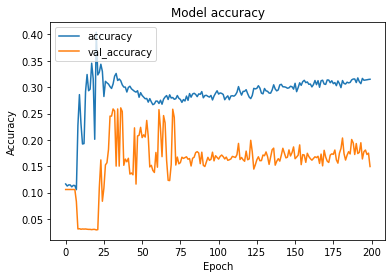

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

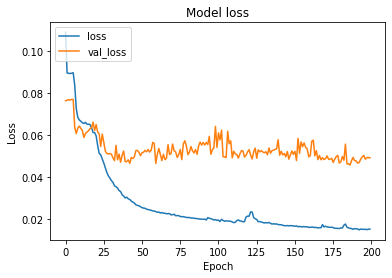

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')

plt.show()

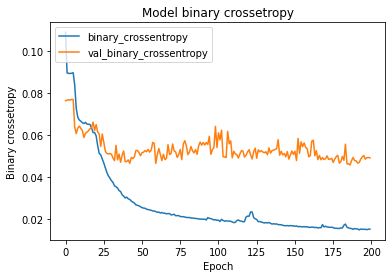

In [13]:
plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [34]:
test2_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i + 2
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test2_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test2_list = np.array(test_list)
test_out = np.array(test_out)

In [35]:
# predict new notes
prediction = model.predict(test2_list, verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)

In [36]:
np.unique(prediction)

array([0, 1])

In [38]:
bpm = 120
file_name = "./output/test2.mid"
create_midi(bpm, prediction, mid.ticks_per_beat, file_name, instruments)
# create_midi(bpm, transcription.values, mid.ticks_per_beat, "./output/transcription.mid", instruments)

In [17]:
def bleu_metric_complete_lines(candidate, reference):
    correct_lines = 0
    for i,c in enumerate(candidate):
        # line of candidate is the same as reference
        if (c == reference[i]).all() == True:
            correct_lines += 1
    
    # probability of correct lines
    return correct_lines/len(reference)

def bleu_metric_ngrams(candidate, reference, ngram):
    correct_ngrams = 0
    offset = 0
    true_flag = True
    
    for i,c in enumerate(candidate):
        
#         print(candidate[i+offset], reference[i+offset], (candidate[i+offset] == reference[i+offset]).all())
        # line is correct
        if (candidate[i] == reference[i]).all() == True:
            pass
        else:
            true_flag = False

        # every ngram sequence
        if (i+1)%ngram == 0:
#             print(i, true_flag)
            # all sequence is correct
            if true_flag:
                correct_ngrams += 1
            true_flag = True
    
    allngrams = len(reference)/ngram
#     print(correct_ngrams, allngrams)
    # probability of correct lines
    return correct_ngrams/allngrams

def bleu_metric_single_notes(candidate, reference, length_of_line):
    correct_lines = 0
    probabilities = []
    for i,c in enumerate(candidate):
        # how many notes are correct in single line
        tmp = ((c == reference[i]) == True).sum()
        # probability of correct notes in single line
        probabilities.append(tmp/length_of_line)
    
    # geometric mean of probabilities
    return gmean(probabilities)

In [18]:
candidate = prediction.copy()
reference = test_list.copy()

In [19]:
bleu_metric_complete_lines(candidate, reference)

0.0

In [20]:
bleu_metric_single_notes(candidate, reference, length_of_line=len(instruments))

30.836420773258553

In [21]:
bleu_metric_ngrams(candidate, reference, 16)

0.0